# Data

In [1]:
import yfinance as yf
import pandas as pd

def get_fred_data(fred, series_id: str, label=None):
    """
    Fetches time series data from FRED (Federal Reserve Economic Data) for a given series ID.

    Args:
    - fred: FRED API object or client.
    - series_id (str): Identifier for the specific time series data on FRED.
    - label (str, optional): Label for the data. Defaults to None.

    Returns:
    - pd.DataFrame: DataFrame containing time series data for the specified series ID.
    """
    data = fred.get_series(series_id)
    data = pd.DataFrame(data).reset_index()
    data.columns = ['date', label or series_id]  # Use label if provided, otherwise use series_id
    data['date'] = pd.to_datetime(data['date'])
    data = data.ffill()
    return data


def get_yfinance_data(ticker: str, label=None, start_date=None, end_date=None):
    """
    Fetches historical price data using yfinance for a given ticker symbol within a specified date range.

    Args:
    - ticker (str): Ticker symbol of the asset (e.g., stock, commodity, etc.).
    - label (str, optional): Label for the data. Defaults to None.
    - start_date (str, optional): Start date in 'YYYY-MM-DD' format. Defaults to None.
    - end_date (str, optional): End date in 'YYYY-MM-DD' format. Defaults to None.

    Returns:
    - pd.DataFrame: DataFrame containing historical price data for the specified ticker and date range.
    """
    if start_date and end_date:
        data = yf.download(ticker, start=start_date, end=end_date)
    else:
        data = yf.download(ticker)
    
    # Reset index and rename columns
    data.reset_index(inplace=True)
    data.rename(columns={'Date': 'date'}, inplace=True)
    
    # Ensure 'date' column is in datetime format
    data['date'] = pd.to_datetime(data['date'])
    
    # If label provided, rename the data column
    if label:
        data.rename(columns={'Close': label}, inplace=True)
    
    return data[['date', label or 'Close']]  # Return only 'date' and 'Close' columns if label not provided

In [2]:
# Import necessary libraries
import yfinance as yf
from fredapi import Fred
import pandas as pd

# Initialize the FRED API
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')  # Replace 'YOUR_FRED_API_KEY' with your actual API key

# Define the dictionaries
fred_data = {
    '10y bond': 'DGS10',
    'oil': 'DCOILWTICO',
    'inflation': 'CPIAUCSL',
    'unemployment': 'UNRATE',
    # 'gdp': 'GDP',
    'fed funds': 'FEDFUNDS',
    # 'GDP': 'GDP',
    'U.S. Dollar Index': 'DTWEXBGS',
    # 'Consumption': 'PCE',
    'Income': 'PI',
}

yfinance_data = {
    # 'gold': 'GC=F',
    # 'silver': 'SI=F',
    # 'bitcoin': 'BTC-USD',
    # 'ethereum': 'ETH-USD',
    # 'S&P 500': '^GSPC',
    # 'JPM': 'JPM',
    'Market Volatility': '^VIX', # CBOE Volatility Index (VIX)
}

# Pull data from FRED for variables in fred_data
fred_datasets = {}
for label, series_id in fred_data.items():
    fred_datasets[label] = get_fred_data(fred, series_id, label=label)

# Pull data from Yahoo Finance for variables in yfinance_data
yfinance_datasets = {}
for label, ticker in yfinance_data.items():
    yfinance_datasets[label] = get_yfinance_data(ticker, label=label)

# Merge all datasets on the 'date' column
merged_data = None
for dataset in [fred_datasets, yfinance_datasets]:
    for label, data in dataset.items():
        if merged_data is None:
            merged_data = data
        else:
            merged_data = pd.merge(merged_data, data, on='date', how='outer')

# Display or further process the merged datal,.jnmhhhhhhhhhhhhhhhhhhhhhhhhhhhhh
df = merged_data
# print(df.head())

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='date'>

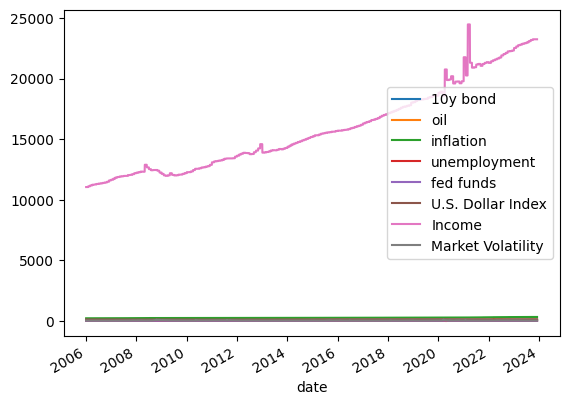

In [3]:
# dff = df.copy()

# sort by date
df.sort_values(by='date', inplace=True)

df.ffill(inplace=True)
# df.bfill(inplace=True)
# drop missing values

df.dropna(inplace=True)

df.plot(x = 'date')

# drop dates before 

In [4]:
# shift bonds up by 1
df['10y bond t+1'] = df['10y bond'].shift(-1)

In [5]:
# plot df using plotly

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers.default = 'browser'

# Assuming df is your DataFrame containing the data

# drop data before 2001 and after November 2023
df = df[(df['date'] >= '2001-01-01') & (df['date'] <= '2023-11-01')]

fig = px.line(df, x='date', y=df.columns, title='data')
fig.update_layout(title='Asset Prices', xaxis_title='Date', yaxis_title='Price')
fig.show()

# Feature Engineering

### Correlation Matrix

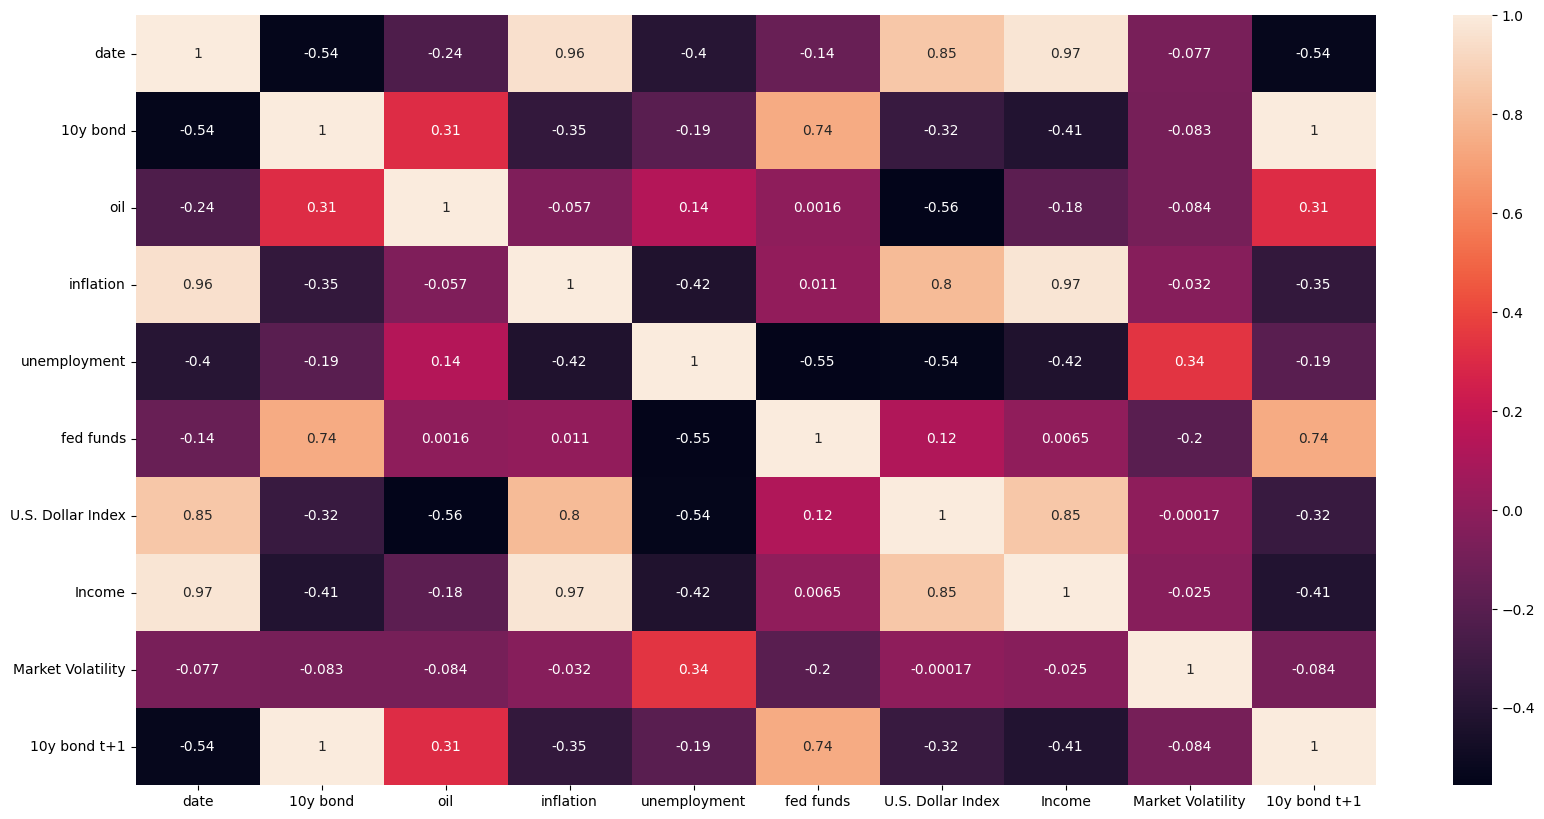

In [6]:
# create a correlation matrix for my df
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True)
plt.show()

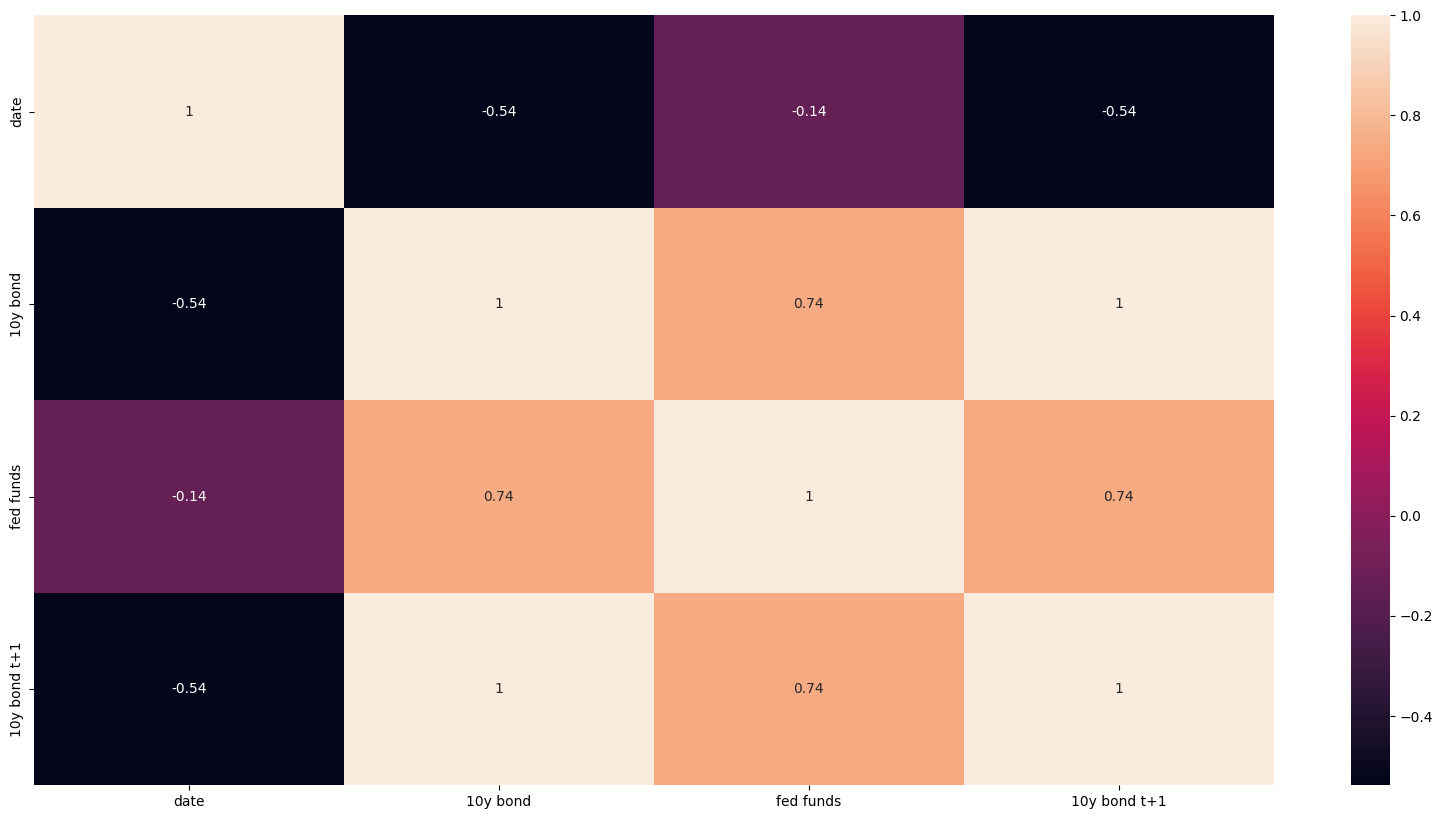

In [7]:
# drop all columns that have less than a absulute value of 0.5 correlation with the 10y bond

# Filter columns based on their correlation with '10y bond' and drop columns with correlation < 0.5
columns_to_drop = corr[abs(corr['10y bond']) < 0.5].index
df_filtered = df.drop(columns=columns_to_drop)

# Create a new correlation matrix for the filtered DataFrame
corr_filtered = df_filtered.corr()

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(corr_filtered, annot=True)
plt.show()

C:\Users\ianda\AppData\Local\Temp\ipykernel_12780\1479146112.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

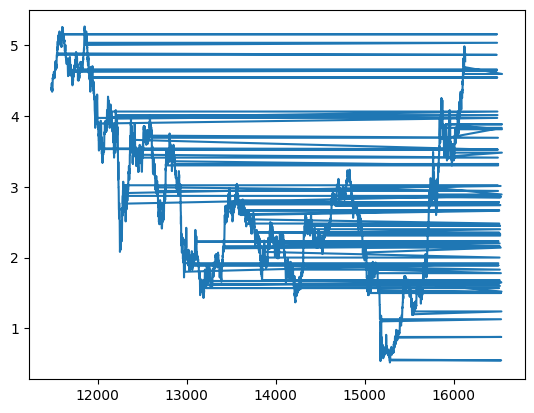

In [11]:
# sort by date
df.sort_values(by='date', inplace=True)

df['10y bond'].plot()

# ACF and PACF

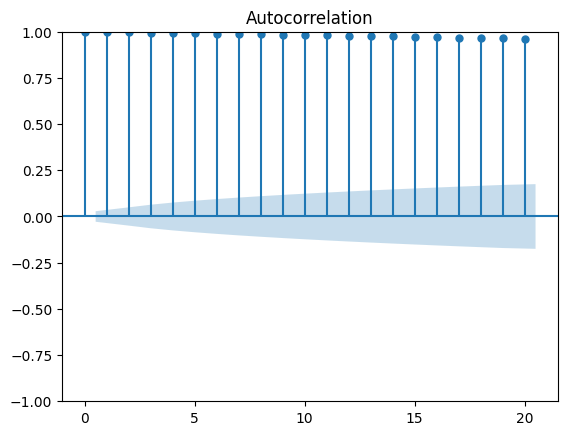

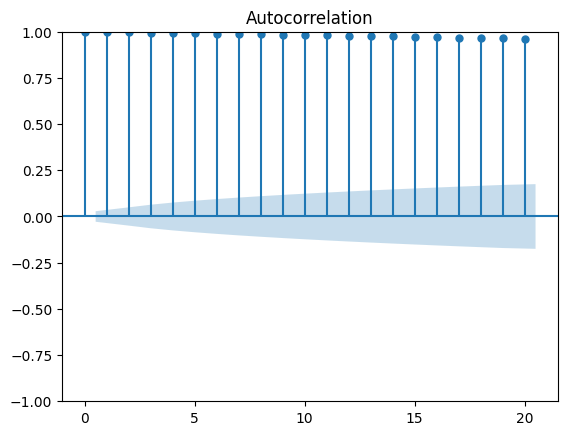

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import matplotlib.pyplot as plt

# # Plot ACF for 10y bond
plot_acf(df['10y bond'].dropna(), lags=20)

# # Plot PACF for 10y bond
# plot_pacf(df['10y bond'], lags=20)

In [10]:
df[['date','10y bond']]

,date,10y bond
11479,2006-01-02,4.39
11480,2006-01-03,4.37
11481,2006-01-04,4.36
11482,2006-01-05,4.36
11483,2006-01-06,4.38
...,...,...
16127,2023-10-26,4.86
16128,2023-10-27,4.84
16129,2023-10-30,4.88
16130,2023-10-31,4.88


# Model